<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/Brg1_KD_sustained_Etv2_peaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Brg1 KD ATAC-seq

by Wuming Gong



In [1]:
start_time0 <- Sys.time()

### Install external packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

### Install R packages

In [64]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'BSgenome.Mmusculus.UCSC.mm10', 'BiocParallel', 'ComplexHeatmap', 
  'rtracklayer', 'EnrichedHeatmap', 'ChIPpeakAnno', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 
  'org.Mm.eg.db', 'clusterProfiler', 'ReactomePA'
), Ncpus = 2)
install.packages(c('devtools', 'gplots', 'circlize', 'dplyr'))


Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'SummarizedExperiment', 'BSgenome.Mmusculus.UCSC.mm10',
  'BiocParallel', 'ComplexHeatmap', 'rtracklayer', 'EnrichedHeatmap',
  'ChIPpeakAnno', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene',
  'org.Mm.eg.db', 'clusterProfiler', 'ReactomePA'

also installing the dependencies 'checkmate', 'reactome.db', 'graphite'


Old packages: 'broom', 'htmlwidgets', 'readr', 'foreign'

Installing packages into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



### Install `DirichletMultinomial` package required for `chromVAR`

In [4]:
install.packages('gsl')
BiocManager::install("DirichletMultinomial")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'DirichletMultinomial'

Old packages: 'broom', 'htmlwidgets', 'readr', 'foreign'



### Install `chromVAR` and `chromVARmotifs`

In [56]:
BiocManager::install(c('chromVAR', 'motifmatchr'), Ncpus = 2)
devtools::install_github("GreenleafLab/chromVARmotifs")

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'chromVAR', 'motifmatchr'

Old packages: 'broom', 'htmlwidgets', 'readr', 'foreign'

Skipping install of 'chromVARmotifs' from a github remote, the SHA1 (38bed559) has not changed since last install.
  Use `force = TRUE` to force installation



### Load R packages

In [65]:
library(chromVARmotifs)
library(chromVAR)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
register(MulticoreParam(2))
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(dplyr)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(rtracklayer)
library(parallel)
library(ChIPpeakAnno)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(clusterProfiler)
library(ReactomePA)

ReactomePA v1.32.0  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479



In [7]:
data("homer_pwms") 

## Read and process the ATAC-seq read counts data 
Read data for each sample and count the motifs at each interval

In [8]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228a/all_ATAC.rds')))
se

class: RangedSummarizedExperiment 
dim: 152282 30 
metadata(0):
assays(1): counts
rownames(152282): chr1 chr1 ... chrY chrY
rowData names(3): score source group
colnames(30): EB_Dox_D25_rep1 EB_Dox_D25_rep2 ...
  MEF_Brg1_KD_NoDox_D7_rep1 MEF_Brg1_KD_NoDox_D7_rep2
colData names(3): bw_file name group

In [9]:
# remove intervals that have reads in at zero or one condition
se <- se[rowSums(assays(se)$counts > 0) >= 2] 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
colData(se)$is_MEF <- grepl('^MEF_', colData(se)$group)
colData(se)$is_EB <- grepl('^EB_', colData(se)$group)
colData(se)$is_flk1pos <- grepl('Flk1pos', colData(se)$group)
colData(se)$is_dox <- grepl('_Dox_', colData(se)$group)
colData(se)$is_Brg1_KD <- grepl('_Brg1_', colData(se)$group)
time <- gsub('_Flk1pos', '', gsub('.+_(D.+)$', '\\1', colData(se)$group))
time[time == 'MEF_NoDox'] <- 'D0'
colData(se)$time <- time

In [10]:
MEF_cols <- colorpanel(4, low = 'black', high = 'green') # time
EB_col <- 'red'
group2col <- c(
  'MEF_NoDox' = MEF_cols[1],
  'MEF_Dox_D1' = MEF_cols[2],
  'MEF_Dox_D2' = MEF_cols[3],
  'MEF_Dox_D7' = MEF_cols[4],
  'MEF_Dox_D7_Flk1pos' = MEF_cols[4],

  'EB_NoDox_D25' = EB_col,
  'EB_Dox_D25' = EB_col,
  'EB_Dox_D25_Flk1pos' = EB_col,
  
  'MEF_Brg1_KD_D0' = MEF_cols[1],
  'MEF_Brg1_KD_Dox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_Dox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_Dox_D7' = MEF_cols[4],
  
  'MEF_Brg1_KD_NoDox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_NoDox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_NoDox_D7' = MEF_cols[4]
)
pch <- rep(21, ncol(se))
pch[colData(se)$is_Brg1_KD] <- 24
colData(se)$pch <- pch
colData(se)$bg <- group2col[as.character(colData(se)$group)]
colData(se)$col <- group2col[as.character(colData(se)$group)]
colData(se)                             

DataFrame with 30 rows and 12 columns
                                                                                                                                                        bw_file
                                                                                                                                                       <factor>
EB_Dox_D25_rep1                             https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep1_treat_pileup.bw        
EB_Dox_D25_rep2                             https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep2_treat_pileup.bw        
EB_NoDox_D25_rep1                           https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep1_treat_pileup.bw      
EB_NoDox_D25_rep2                           https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep2_treat_pileup.bw      
EB

## chromVAR analysis

In [11]:
set.seed(1)
include <- colData(se)$is_MEF & colData(se)$time == 'D7'
se_D7 <- se[, include]
se_D7 <- se_D7[rowSums(assays(se_D7)$counts > 0) >= 2]
motif_ix <- matchMotifs(homer_pwms, se_D7, genome = 'mm10')
dev_D7 <- computeDeviations(object = se_D7, annotations = motif_ix)
v_D7 <- computeVariability(dev_D7)

PCA of the motif deiviations

# of significant motifs: 229(332)


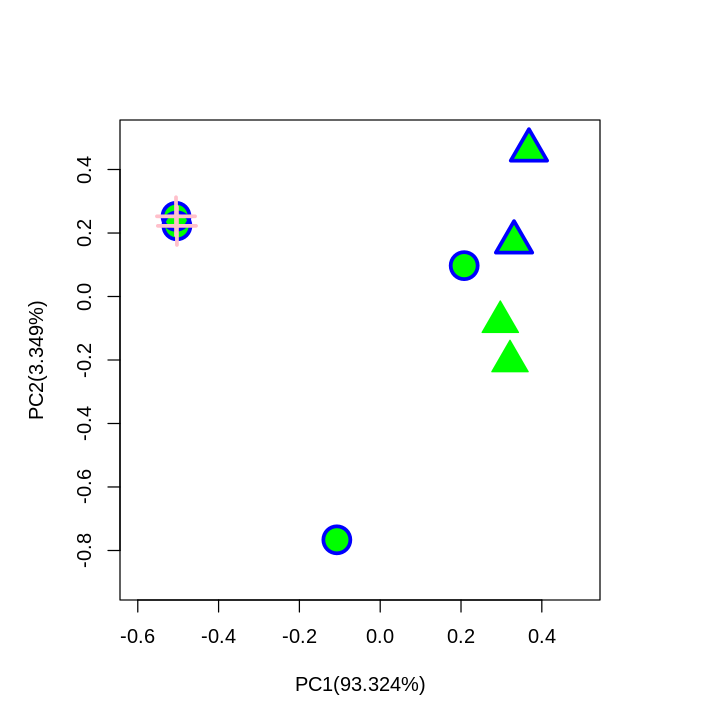

In [12]:
m <- v_D7$p_value_adj < 1e-10
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
s <- prcomp(assays(dev_D7)$z[m, ])
eigs <- s$sdev^2
z <- s$rotation

pc_x <- 1; pc_y <- 2
cex <- 3

par(mar = c(5, 5, 5, 5))
options(repr.plot.width=6, repr.plot.height=6)
plot(
  z[, pc_x], z[, pc_y], 
  pch = colData(se_D7)$pch, 
  bg = colData(se_D7)$bg, 
  col = colData(se_D7)$col, 
  cex = cex, 
  xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), 
  ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100),
  xlim = c(-0.6, 0.5),
  ylim = c(-0.9, 0.5)
)
points(
  z[colData(se_D7)$is_dox, pc_x], z[colData(se_D7)$is_dox, pc_y], 
  pch = colData(se_D7)$pch[colData(se_D7)$is_dox], 
  col = 'blue', 
  cex = cex, 
  lwd = 3
)
points(
  z[colData(se_D7)$is_flk1pos, pc_x], z[colData(se_D7)$is_flk1pos, pc_y], 
  pch = 3, 
  col = 'pink', 
  cex = cex, 
  lwd = 3
)

# of significant motifs: 46(332)


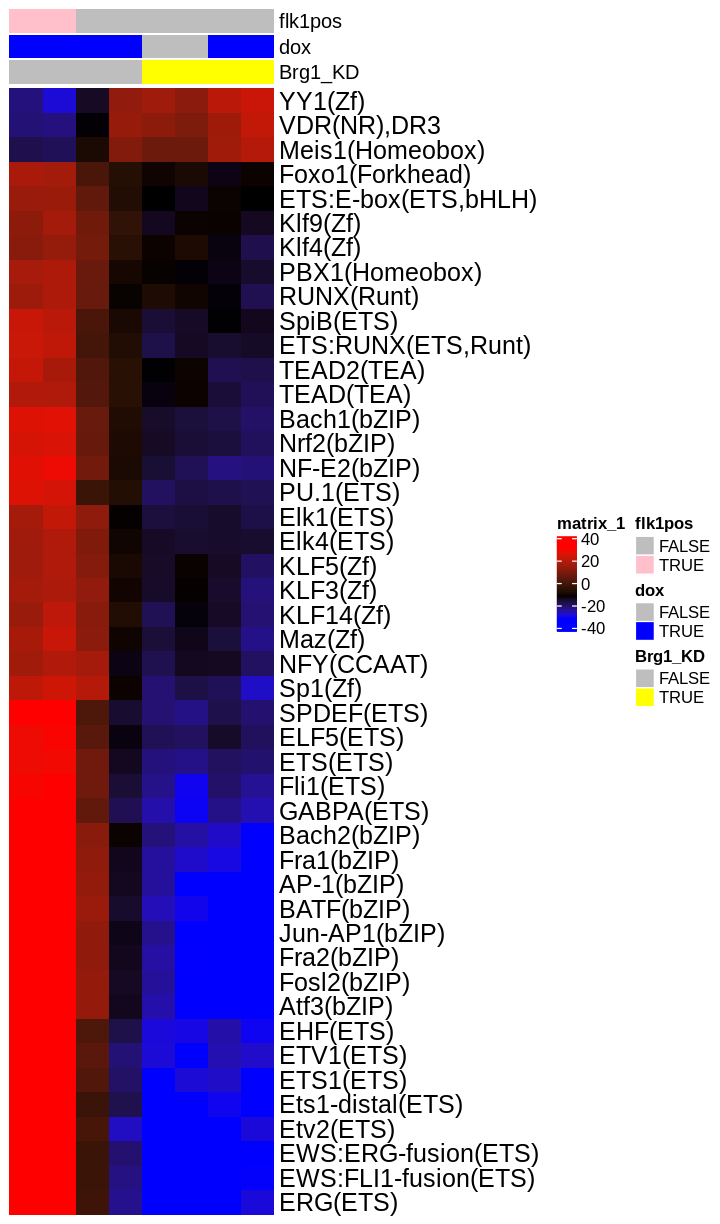

In [13]:
m <- v_D7$p_value_adj < 1e-200
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
Y <- assays(dev_D7)$z
rownames(Y) <- rowData(dev_D7)$name
Y <- Y[m, ]

column_annotation <- HeatmapAnnotation(
  flk1pos = colData(se_D7)$is_flk1pos,
  dox = colData(se_D7)$is_dox,
#  time = colData(se_D7)$time,
  Brg1_KD = colData(se_D7)$is_Brg1_KD,
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray'),
    Brg1_KD  = c('TRUE' = 'yellow', 'FALSE' = 'gray'),
    time = c('D0' = MEF_cols[1], 'D1' = MEF_cols[2],'D2' = MEF_cols[3],'D7' = MEF_cols[4])
  )
)

col_fun <- colorRamp2(quantile(Y, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=6, repr.plot.height = nrow(Y) * 0.2 + 1)
Heatmap(
  Y,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_gp = gpar(fontsize = 15)
)

At D7, The Etv2 motif associated chromatin accessibility decreased in Brg1 KD cells, compared with the WT reprogramming. This suggest that Brg1 may help to retain the Etv2 bindings on the chromatin, not so much related to the initialization.

## Get sustained Etv2 ChIP-seq peaks
Split the Etv2 MEF D1 peaks into three groups
* on at D1 and off at D7 (early)
* off at D1 and on at D7 (late)
* on at both D1 and D7 (sustained)

In [14]:
gr_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds' 
gr <- readRDS(gzcon(url(gr_url)))
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]
peaks

GRanges object with 127559 ranges and 4 metadata columns:
           seqnames            ranges strand |
              <Rle>         <IRanges>  <Rle> |
       [1]     chr1   3037784-3037983      * |
       [2]     chr1   3490314-3490513      * |
       [3]     chr1   3531626-3531825      * |
       [4]     chr1   3671125-3671324      * |
       [5]     chr1   3671746-3671945      * |
       ...      ...               ...    ... .
  [127555]     chrY 90828936-90829135      * |
  [127556]     chrY 90836259-90836458      * |
  [127557]     chrY 90841624-90841823      * |
  [127558]     chrY 90842563-90842762      * |
  [127559]     chrY 90843810-90844009      * |
                                                                                                                 peak_id
                                                                                                             <character>
       [1]      /panfs/roc/scratch/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=2

Select the sustained Etv2 ChIP-seq peaks that are present in both D1 and D7 post induction.

In [15]:
is_sustained <- peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2']
peaks_sustained <- peaks[is_sustained]
cat(sprintf('# of sustained Etv2 ChIP-seq peaks: %d', sum(is_sustained)))

# of sustained Etv2 ChIP-seq peaks: 12170

## Download MACS2 pileup files of ATAC-seq

In [16]:
bw_files <- c(
  'MEF_Dox_D1_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
  'MEF_Dox_D2_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
  'MEF_Dox_D7_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
  'MEF_NoDox_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
  'MEF_Dox_D1_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
  'MEF_Dox_D2_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
  'MEF_Dox_D7_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
  'MEF_Brg1_KD_D0' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_D0_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D1_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D2_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D1_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D2_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D7_treat_pileup.bw',
  'MEF_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_treat_pileup.bw',
  'MEF_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2_treat_pileup.bw',
  'MEF_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_treat_pileup.bw',
  'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_treat_pileup.bw',
  'MEF_NoDox' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_treat_pileup.bw'
)

Download MACS2 pileup files (in BigWig format)
It appears that `rtracklayer::import` does not support importing bigwig files with URL starting with 'https://'.  We need to download the bigwig files first.


In [17]:
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)
commands <- sprintf('wget -x -c -nH %s', bw_files)
lapply(commands, function(command) system(command))
file.exists(local_bw_files)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE

## Read the ATAC-seq summits

In [18]:
# ATAC-seq summits of Brg1 KD at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_summits.bed'
peaks_Brg1KD_D7 <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_Brg1KD_D7 <- GRanges(seqnames = peaks_Brg1KD_D7[, 1], range = IRanges(peaks_Brg1KD_D7[, 2], peaks_Brg1KD_D7[, 3]))

# ATAC-seq summits WT MEF reprogramming at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_summits.bed'
peaks_D7_Flk1pos <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_D7_Flk1pos <- GRanges(seqnames = peaks_D7_Flk1pos[, 1], range = IRanges(peaks_D7_Flk1pos[, 2], peaks_D7_Flk1pos[, 3]))

# ATAC-seq blacklist
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/datasets=blacklists_version=20190827a/mm10.blacklist.bed.gz'
peaks_blacklist <- gzcon(url(bed_file))
peaks_blacklist <- readLines(peaks_blacklist)
peaks_blacklist <- read.table(textConnection(peaks_blacklist), header = FALSE, sep = '\t')
peaks_blacklist <- GRanges(seqnames = peaks_blacklist[, 1], range = IRanges(peaks_blacklist[, 2], peaks_blacklist[, 3]))

## get_normalizeToMatrix
Generate the normalizeToMatrix object for visualizing ChIP-seq-like data by `EnrichedHeatmap`. 

In [27]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(peaks_sustained)[1]
cat(sprintf('# peaks: %d\n', length(peaks)))
cat(sprintf('target width: %d\n', target_width))

# peaks: 127559
target width: 200


In [28]:
get_normalizeToMatrix <- function(bw_file, peaks, extend, w, smooth = FALSE, target_ratio = 0.2, ...){
  cvg <- rtracklayer::import(bw_file, which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2))))  # returned as a GRanges object
  mat <- normalizeToMatrix(cvg, peaks, extend = extend, value_column = 'score', mean_mode = 'w0', w = w, smooth = smooth, target_ratio = target_ratio, ...)
  mat
} # get_normalizeToMatrix

## Prepare normalized matrix for EnrichedHeatmap

In [43]:
mat <- mclapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(peaks_sustained, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    peaks_sustained, 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
}, mc.cores = 2)

## Make the heatmap

Color scheme of the heatmap

In [45]:
group_cols <- c(
  'MEF_Dox_D1_Etv2' = 'red',
  'MEF_Dox_D2_Etv2' = 'red',
  'MEF_Dox_D7_Etv2' = 'red',
  'MEF_NoDox_Brg1' = 'purple',
  'MEF_Dox_D1_Brg1' = 'purple',
  'MEF_Dox_D2_Brg1' = 'purple',
  'MEF_Dox_D7_Brg1' = 'purple',
  'MEF_Brg1_KD_D0' = 'blue',
  'MEF_Brg1_KD_Dox_D1' = 'blue',
  'MEF_Brg1_KD_Dox_D2' = 'blue',
  'MEF_Brg1_KD_Dox_D7' = 'blue',
  'MEF_Brg1_KD_NoDox_D1' = 'blue',
  'MEF_Brg1_KD_NoDox_D2' = 'blue',
  'MEF_Brg1_KD_NoDox_D7' = 'blue',
  'MEF_Dox_D1' = 'blue',
  'MEF_Dox_D2' = 'blue',
  'MEF_Dox_D7' = 'blue',
  'MEF_Dox_D7_Flk1pos' = 'blue',
  'MEF_NoDox' = 'blue'
)
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

In [46]:
open_Brg1KD_D7 <- peaks_sustained %over% peaks_Brg1KD_D7
open_D7_Flk1pos <-peaks_sustained %over% peaks_D7_Flk1pos
is_black <- peaks_sustained %over% peaks_blacklist

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting

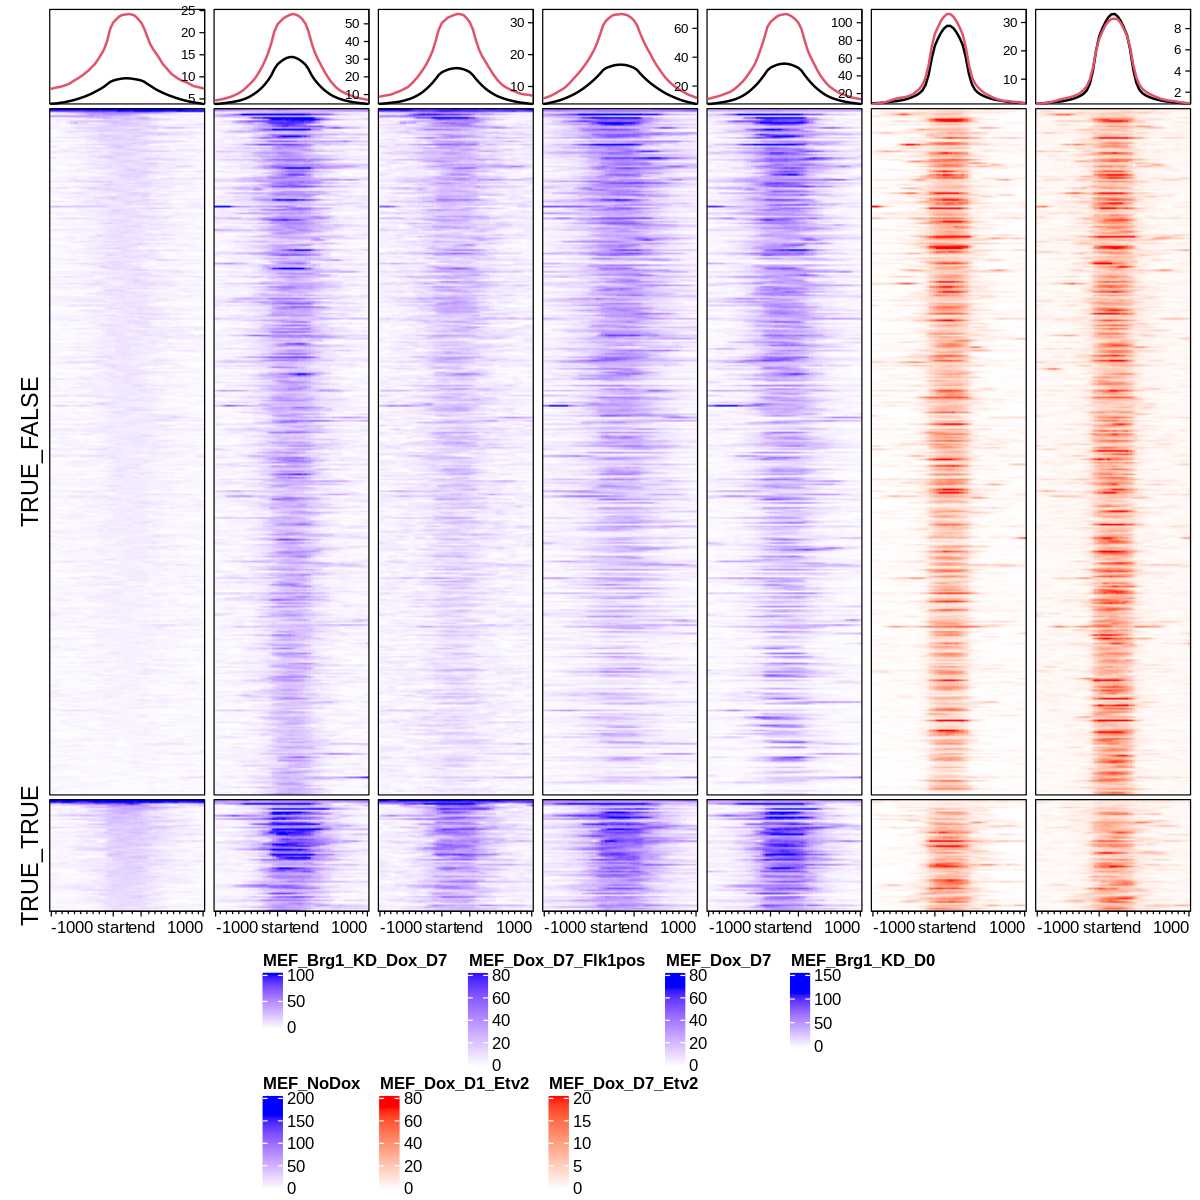

In [47]:
i <- which(open_D7_Flk1pos & !is_black)
sp <- factor(sprintf('%s_%s', open_D7_Flk1pos, open_Brg1KD_D7))
              
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside')
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Brg1_KD_Dox_D7']][i, ], 
  col = col_fun[['MEF_Brg1_KD_Dox_D7']], 
  split = sp[i], 
  name = 'MEF_Brg1_KD_Dox_D7', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D7_Flk1pos','MEF_Dox_D7',
  'MEF_Brg1_KD_D0', 'MEF_NoDox',
  'MEF_Dox_D1_Etv2', 'MEF_Dox_D7_Etv2'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

The sustaina Etv2 peaks can be dividied into two groups

* Group 1: closed in Brg1 KO at D7 (TRUE_FALSE)
* Group 2: open in Brg1 KO at D7 (TRUE_TRUE)

In [ ]:
The sustaina Etv2 peaks can be dividied into two groups

Group 1: closed in Brg1 KO at D7 (TRUE_FALSE)
Group 2: open in Brg1 KO at D7 (TRUE_TRUE)

## Annotating open vs. closed Etv2 peaks (sustained)

In [54]:
peak_list <- list(
  open = peaks_sustained[open_D7_Flk1pos & open_Brg1KD_D7],
  closed = peaks_sustained[open_D7_Flk1pos & !open_Brg1KD_D7]
)
anno_list <- lapply(peak_list, function(p)
  annotatePeak(p, tssRegion = c(-5000, 1000), TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene, annoDb = "org.Mm.eg.db")
)


>> preparing features information...		 2020-10-05 05:42:43 PM 
>> identifying nearest features...		 2020-10-05 05:42:44 PM 
>> calculating distance from peak to TSS...	 2020-10-05 05:42:45 PM 
>> assigning genomic annotation...		 2020-10-05 05:42:45 PM 
>> adding gene annotation...			 2020-10-05 05:43:07 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2020-10-05 05:43:07 PM 
>> done...					 2020-10-05 05:43:07 PM 
>> preparing features information...		 2020-10-05 05:43:07 PM 
>> identifying nearest features...		 2020-10-05 05:43:07 PM 
>> calculating distance from peak to TSS...	 2020-10-05 05:43:07 PM 
>> assigning genomic annotation...		 2020-10-05 05:43:07 PM 
>> adding gene annotation...			 2020-10-05 05:43:10 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2020-10-05 05:43:10 PM 
>> done...					 2020-10-05 05:43:10 PM 


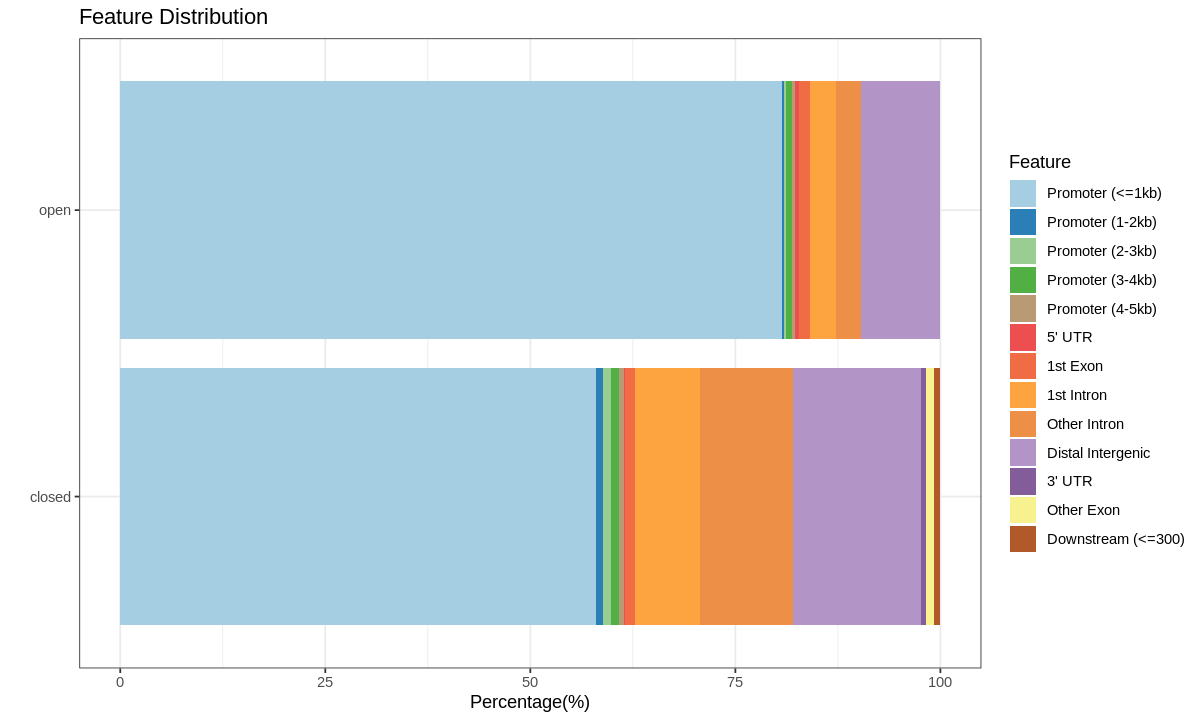

In [59]:
options(repr.plot.width=10, repr.plot.height=6)
plotAnnoBar(anno_list)

In [60]:
# Find the genes near the peaks
gene_list <- lapply(peak_list, function(p){
  unique(seq2gene(p, tssRegion = c(-5000, 1000), flankDistance = 3000, TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene))
})

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



GO pathways that are enriched in the genes near the `closed` Etv2 peaks.

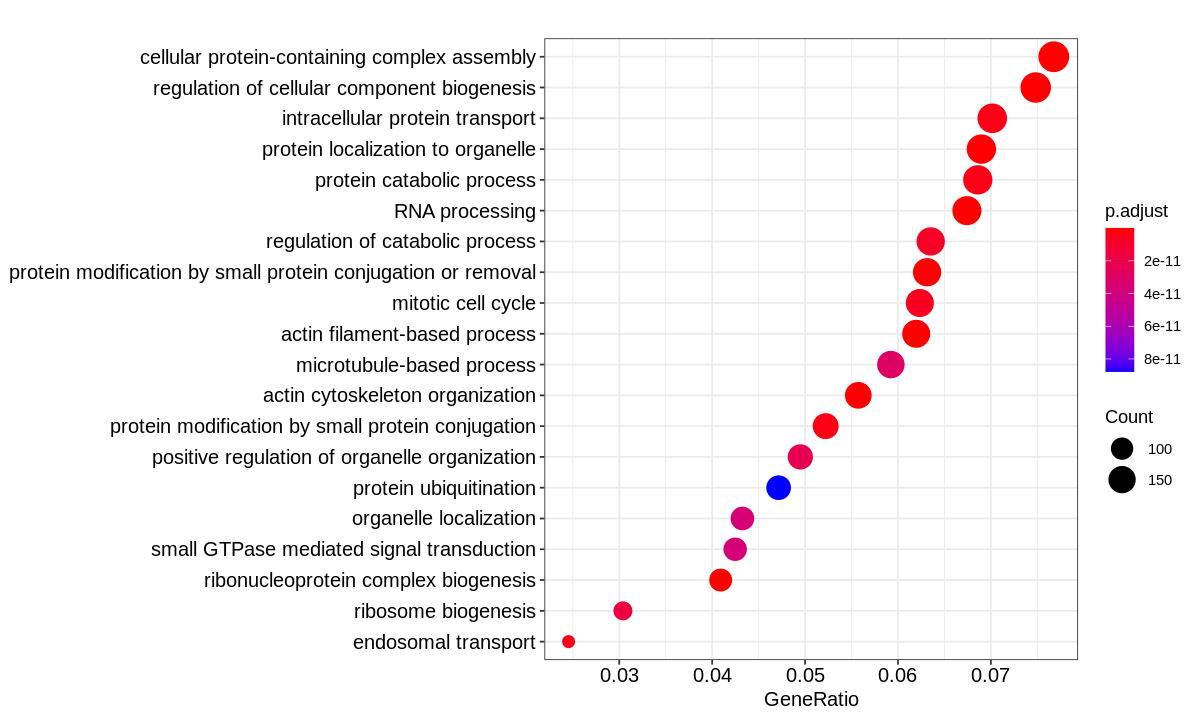

In [61]:
pathway_list <- lapply(gene_list, function(g){
  enrichGO(g, keyType = "ENTREZID", OrgDb = org.Mm.eg.db, ont = 'BP', minGSSize = 50, maxGSSize = 1000)
})
dotplot(pathway_list[['closed']], showCategory = 20)

Reactome pathways that are enriched in the genes near the `closed` Etv2 peaks.

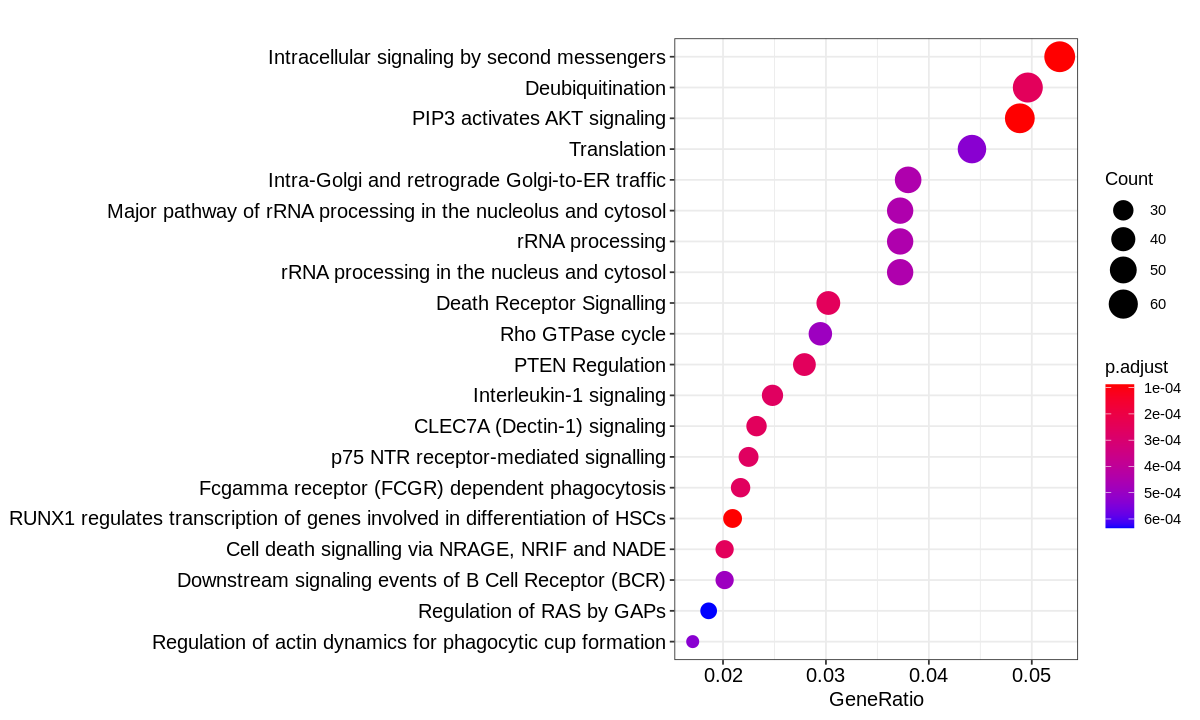

In [66]:
pathway_list <- lapply(gene_list, function(g){
  enrichPathway(g, organism = 'mouse')
})
dotplot(pathway_list[['closed']], showCategory = 20)

In [ ]:
Sys.time() - start_time0

Time difference of 46.19382 mins

In [67]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ReactomePA_1.32.0                        
 [2] clusterProfiler_3.16.1                   
 [3] org.Mm.eg.db_3.11.4                      
 [4] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0
 [5] GenomicFeatures_1.40.1                   